# ENEDIS

## Context 

Our client is a resource manager working for the government. His leadership asked him to investigate
yearly electricity consumption and try to explain it based on external data (demographic, weather,
economic…) in order to forecast years to come in each IRIS or town in France. He has instructed us to
assist him with our expertise.
As part of Accenture Analytics, you integrate the team involved in that project.

In [2]:
# Load needed Libraries 
import pandas as pd
import numpy as np
import sklearn
import re
import math

# to make this notebook's output identical at every run
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# To show more column when using df.head()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Get the Data

First we begin by downloading each files using the website belows
* https://data.enedis.fr/explore/dataset/consommation-electrique-par-secteur-dactivite-iris/information/
* https://www.insee.fr/fr/statistiques/3137421#dictionnaire
* https://www.insee.fr/fr/statistiques/3137412#dictionnaire
* https://www.insee.fr/fr/statistiques/3137409#dictionnaire

Then we will read the first 5 lines using the DataFrame's `head()` method

In [3]:
raw_consoPerIris = pd.read_csv('consommation-electrique-par-secteur-dactivite-iris.csv', sep=';', error_bad_lines=False)
raw_consoPerIris.head()

Année                           Nom IRIS  Code IRIS Type IRIS     Nom commune  Code commune                            Nom EPCI  Code EPCI Type EPCI       Nom département  Code département            Nom région  Code région  Nb sites Résidentiel  Conso totale Résidentiel (MWh)  Conso moyenne Résidentiel (MWh)  Conso totale Résidentiel usages thermosensibles (MWh)  Conso totale Résidentiel usages non thermosensibles (MWh)  Conso moyenne Résidentiel usages thermosensibles (MWh)  Conso moyenne Résidentiel usages non thermosensibles (MWh)  Part thermosensible Résidentiel (%)  Thermosensibilité totale Résidentiel (kWh/DJU)  Thermosensibilité moyenne Résidentiel (kWh/DJU)  Conso totale corrigée de l'aléa climatique Résidentiel usages thermosensibles (MWh)  Conso moyenne corrigée de l'aléa climatique Résidentiel usages thermosensibles (MWh)  Nb sites Professionnel  Conso totale Professionnel (MWh)  Conso moyenne Professionnel (MWh)  DJU  Nb sites Agriculture  \
0   2014            Kerallan-Pen Ar Ch'Leuz  290190157         H           Brest         29019           CU Brest Métropole Océane  242900314        CU             Finistère                29              Bretagne           53                1131.0                     4215.912353                         3.727597                                                NaN                                                    NaN                                                        NaN                                                     NaN                                           NaN                                             NaN                                              NaN                                                NaN                                                                                  NaN                                                       87.0                        706.146914                           8.116631  NaN                     0   
1   2014   Saint-Maden (commune non irisée)  223120000         Z     Saint-Maden         22312               CC du Pays de Caulnes  242200608        CC         Côtes-d'Armor                22              Bretagne           53                 112.0                      623.709867                         5.568838                                                NaN                                                    NaN                                                        NaN                                                     NaN                                           NaN                                             NaN                                              NaN                                                NaN                                                                                  NaN                                                       15.0                        418.281773                          27.885452  NaN                     3   
2   2014                       Mairie-Marne  641220102         H        Biarritz         64122  CA Agglomération Côte Basque Adour  246400030        CA  Pyrénées-Atlantiques                64    Nouvelle Aquitaine           75                3051.0                     6975.434955                         2.286278                                                NaN                                                    NaN                                                        NaN                                                     NaN                                           NaN                                             NaN                                              NaN                                                NaN                                                                                  NaN                                                      559.0                       3736.773298                           6.684747  NaN                     0   
3   2014                        Pave Neuf 4  930510304         H  Noisy-le-Grand         93051                     

In [4]:
xls = pd.ExcelFile('base-ic-evol-struct-pop-2014.xls')
evolStrucPop = xls.parse('IRIS', skiprows=5, index_col=None, na_values=['NA'])
evolStrucPop.head()

IRIS  REG DEP UU2010    COM                   LIBCOM  TRIRIS GRD_QUART                                       LIBIRIS TYP_IRIS  MODIF_IRIS LAB_IRIS      P14_POP  P14_POP0002  P14_POP0305  P14_POP0610  P14_POP1117  P14_POP1824  P14_POP2539  P14_POP4054  P14_POP5564  P14_POP6579  P14_POP80P  P14_POP0014  P14_POP1529  P14_POP3044  P14_POP4559  P14_POP6074  P14_POP75P  P14_POP0019  P14_POP2064  P14_POP65P     P14_POPH   P14_H0014   P14_H1529   P14_H3044   P14_H4559   P14_H6074    P14_H75P   P14_H0019    P14_H2064    P14_H65P     P14_POPF   P14_F0014   P14_F1529   P14_F3044   P14_F4559   P14_F6074    P14_F75P   P14_F0019    P14_F2064    P14_F65P   C14_POP15P  C14_POP15P_CS1  C14_POP15P_CS2  C14_POP15P_CS3  C14_POP15P_CS4  C14_POP15P_CS5  C14_POP15P_CS6  C14_POP15P_CS7  C14_POP15P_CS8     C14_H15P  C14_H15P_CS1  C14_H15P_CS2  C14_H15P_CS3  C14_H15P_CS4  C14_H15P_CS5  C14_H15P_CS6  C14_H15P_CS7  C14_H15P_CS8     C14_F15P  C14_F15P_CS1  C14_F15P_CS2  C14_F15P_CS3  C14_F15P_CS4  \
0  010010000   84  01  01000  01001  L'Abergement-Clémenciat  ZZZZZZ   0100100  L'Abergement-Clémenciat (commune non irisée)        Z           0        5   767.000000    29.000000    18.000000    57.000000    90.000000    36.000000   106.000000   193.000000    95.000000   111.000000   32.000000   161.000000   102.000000   132.000000   189.000000   125.000000   58.000000   212.000000   412.000000  143.000000   392.000000   84.000000   55.000000   65.000000   99.000000   61.000000   28.000000  113.000000   206.000000   73.000000   375.000000   77.000000   47.000000   67.000000   90.000000   64.000000   30.000000   99.000000   206.000000   70.000000   605.000000       15.000000       20.000000       75.000000       95.000000      100.000000      125.000000      145.000000       30.000000   320.000000     10.000000     15.000000     50.000000     45.000000     15.000000     95.000000     75.000000     15.000000   285.000000      5.000000      5.000000     25.000000     50.000000   
1  010020000   84  01  01000  01002    L'Abergement-de-Varey  ZZZZZZ   0100200    L'Abergement-de-Varey (commune non irisée)        Z           0        5   239.000000    13.769547     9.835391    13.769547    23.604938     7.868313    53.111111    49.176955    24.588477    32.456790   10.818930    54.094650    27.539095    68.847737    36.390947    33.440329   18.687243    64.913580   130.810700   43.275720   120.975309   25.572016    9.835391   37.374486   16.720165   21.637860    9.835391   29.506173    64.913580   26.555556   118.024691   28.522634   17.703704   31.473251   19.670782   11.802469    8.851852   35.407407    65.897119   16.720165   191.790123        0.000000       19.670782       14.753086       24.588477       39.341564        9.835391       63.930041       19.670782   113.106996      0.000000     14.753086      4.917695      4.917695     14.753086      9.835391     44.259259     19.670782    78.683128      0.000000      4.917695      9.835391     19.670782   
2  010040101   84  01  01302  01004        Ambérieu-en-Bugey  ZZZZZZ   0100401              Les Perouses-Triangle d'Activite        H           0        1  1727.477146    74.617146    63.914970   101.000432   108.522248   269.640703   346.747459   276.949028   185.703949   187.656597  112.724611   301.998904   458.829732   304.183905   251.641774   252.783272  158.039559   460.001704   967.094233  300.381209   906.776029  151.142674  270.692051  160.030480  147.767388  112.798908   64.344528  246.974999   531.052783  128.748246   820.701117  150.856229  188.137680  144.153425  103.874386  139.984365   93.695031  213.026704   436.041450  171.632962  1411.478573        0.000000       10.694905       48.224303      170.714930      253.313377      221.232994      370.926900      336.371164   736.633804      0.000000      7.159922     17.086746     98.606084    111.252360    192.157278    156.069551    154.301862   674.844769      0.000000      3.534983     31.137557     72.108846   
3  010040102   84  01  01302  01

In [5]:
xls = pd.ExcelFile('base-ic-couples-familles-menages-2014.xls')
menage = xls.parse('IRIS', skiprows=5, index_col=None, na_values=['NA'])
menage.head()

IRIS  REG DEP UU2010    COM                   LIBCOM  TRIRIS GRD_QUART                                       LIBIRIS TYP_IRIS  MODIF_IRIS LAB_IRIS      C14_MEN  C14_MENPSEUL  C14_MENHSEUL  C14_MENFSEUL  C14_MENSFAM   C14_MENFAM  C14_MENCOUPSENF  C14_MENCOUPAENF  C14_MENFAMMONO     C14_PMEN  C14_PMEN_MENPSEUL  C14_PMEN_MENHSEUL  C14_PMEN_MENFSEUL  C14_PMEN_MENSFAM  C14_PMEN_MENFAM  C14_PMEN_MENCOUPSENF  C14_PMEN_MENCOUPAENF  C14_PMEN_MENFAMMONO   P14_POP15P  P14_POP1524  P14_POP2554  P14_POP5579  P14_POP80P  P14_POPMEN15P  P14_POPMEN1524  P14_POPMEN2554  P14_POPMEN5579  P14_POPMEN80P  P14_POP15P_PSEUL  P14_POP1524_PSEUL  P14_POP2554_PSEUL  P14_POP5579_PSEUL  P14_POP80P_PSEUL  P14_POP15P_MARIEE  P14_POP15P_NONMARIEE  C14_MEN_CS1  C14_MEN_CS2  C14_MEN_CS3  C14_MEN_CS4  C14_MEN_CS5  C14_MEN_CS6  C14_MEN_CS7  C14_MEN_CS8  C14_PMEN_CS1  C14_PMEN_CS2  C14_PMEN_CS3  C14_PMEN_CS4  C14_PMEN_CS5  C14_PMEN_CS6  C14_PMEN_CS7  C14_PMEN_CS8      C14_FAM  C14_COUPAENF  C14_FAMMONO  \
0  010010000   84  01  01000  01001  L'Abergement-Clémenciat  ZZZZZZ   0100100  L'Abergement-Clémenciat (commune non irisée)        Z           0        5   310.000000     70.000000     35.000000     35.000000     5.000000   235.000000       110.000000       110.000000       15.000000   765.000000          70.000000          35.000000          35.000000         10.000000       685.000000            220.000000            425.000000            40.000000   606.000000    69.000000   299.000000   206.000000   32.000000     606.000000       69.000000      299.000000      206.000000      32.000000         66.000000           0.000000          18.000000          36.000000         12.000000         320.000000            286.000000    10.000000    15.000000    45.000000    50.000000    15.000000    75.000000   100.000000     0.000000     20.000000     60.000000    150.000000    100.000000     40.000000    220.000000    175.000000      0.000000   235.000000    110.000000    15.000000   
1  010020000   84  01  01000  01002    L'Abergement-de-Varey  ZZZZZZ   0100200    L'Abergement-de-Varey (commune non irisée)        Z           0        5   103.271605     29.506173     24.588477      4.917695     0.000000    73.765432        34.423868        34.423868        4.917695   255.720165          29.506173          24.588477           4.917695          0.000000       226.213992             68.847737            142.613169            14.753086   184.905350    14.753086   102.288066    57.045267   10.818930     184.905350       14.753086      102.288066       57.045267      10.818930         25.572016           0.000000           9.835391           9.835391          5.901235          87.534979             97.370370     0.000000    14.753086     9.835391     9.835391    14.753086     9.835391    44.259259     0.000000      0.000000     63.930041     34.423868     34.423868     24.588477     34.423868     63.930041      0.000000    73.765432     34.423868     4.917695   
2  010040101   84  01  01302  01004        Ambérieu-en-Bugey  ZZZZZZ   0100401              Les Perouses-Triangle d'Activite        H           0        1   720.327621    371.198686    176.881241    194.317446     3.624940   345.503995       138.402436       152.861366       54.240193  1387.485182         371.198686         176.881241         194.317446          9.062349      1007.224146            277.711108            609.510603           120.002436  1425.478242   315.696597   623.696487   373.360547  112.724611    1131.485191      232.698558      501.699371      331.361540      65.725722        369.198734         120.011616          83.474630         120.787018         44.925470         588.377004            837.101238     0.000000     6.253687    20.969299   122.654296    93.904361   139.721833   222.327757   114.496387      0.000000     25.831027     34.052356    298.324776    184.002220    385.231988    331.755020    128.287795   345.503995    152.861366    54.240193   
3  010040102   84  01  01302  01004        A

In [6]:
xls = pd.ExcelFile('base-ic-logement-2014.xls')
logement = xls.parse('IRIS', skiprows=5, index_col=None, na_values=['NA'])
logement.head()

IRIS  REG DEP UU2010    COM                   LIBCOM  TRIRIS GRD_QUART                                       LIBIRIS TYP_IRIS  MODIF_IRIS LAB_IRIS      P14_LOG       P14_RP  P14_RSECOCC  P14_LOGVAC  P14_MAISON   P14_APPART   P14_RP_1P   P14_RP_2P   P14_RP_3P   P14_RP_4P  P14_RP_5PP  P14_NBPI_RP  P14_RPMAISON  P14_NBPI_RPMAISON  P14_RPAPPART  P14_NBPI_RPAPPART  P14_RP_M30M2  P14_RP_3040M2  P14_RP_4060M2  P14_RP_6080M2  P14_RP_80100M2  P14_RP_100120M2  P14_RP_120M2P  P14_RP_ACHTOT  P14_RP_ACH19  P14_RP_ACH45  P14_RP_ACH70  P14_RP_ACH90  P14_RP_ACH05  P14_RP_ACH11  P14_RPMAISON_ACHTOT  P14_RPMAISON_ACH19  P14_RPMAISON_ACH45  P14_RPMAISON_ACH70  P14_RPMAISON_ACH90  P14_RPMAISON_ACH05  P14_RPMAISON_ACH11  P14_RPAPPART_ACHTOT  P14_RPAPPART_ACH19  P14_RPAPPART_ACH45  P14_RPAPPART_ACH70  P14_RPAPPART_ACH90  P14_RPAPPART_ACH05  P14_RPAPPART_ACH11      P14_MEN  P14_MEN_ANEM0002  P14_MEN_ANEM0204  P14_MEN_ANEM0509  P14_MEN_ANEM10P     P14_PMEN  P14_PMEN_ANEM0002  P14_PMEN_ANEM0204  \
0  010010000   84  01  01000  01001  L'Abergement-Clémenciat  ZZZZZZ   0100100  L'Abergement-Clémenciat (commune non irisée)        Z           0        5   342.734735   306.000000    13.994185   22.740550  335.110825     5.749273    1.000000    3.000000   21.000000  100.000000  181.000000  1521.000000    301.000000        1507.000000      4.000000          10.000000      1.000000       2.000000       4.000000      40.000000       81.000000        74.000000     104.000000     293.000000     84.000000      9.000000      8.000000     94.000000     90.000000      8.000000           288.000000           83.000000            9.000000            6.000000           92.000000           90.000000            8.000000             4.000000            0.000000            0.000000            2.000000            2.000000            0.000000            0.000000   306.000000         24.000000         41.000000         36.000000       205.000000   767.000000          60.000000         122.000000   
1  010020000   84  01  01000  01002    L'Abergement-de-Varey  ZZZZZZ   0100200    L'Abergement-de-Varey (commune non irisée)        Z           0        5   161.160233    99.337449    47.276247   14.546538  161.160233     0.000000    1.967078    1.967078   13.769547   29.506173   52.127572   471.115226     99.337449         471.115226      0.000000           0.000000      0.000000       0.983539       5.901235       7.868313       24.588477        19.670782      40.325103      95.403292     53.111111      9.835391      6.884774      7.868313     11.802469      5.901235            95.403292           53.111111            9.835391            6.884774            7.868313           11.802469            5.901235             0.000000            0.000000            0.000000            0.000000            0.000000            0.000000            0.000000    99.337449         11.802469         14.753086         26.555556        46.226337   239.000000          29.506173          35.407407   
2  010040101   84  01  01302  01004        Ambérieu-en-Bugey  ZZZZZZ   0100401              Les Perouses-Triangle d'Activite        H           0        1   827.982997   719.327645    17.736328   90.919024  317.098225   485.416937  126.108139   58.863456  174.818792  219.061206  140.476052  2443.280946    279.107297        1296.805424    418.118527        1118.561326    134.652478      17.262783     107.102430     170.480899      189.265783        54.263661      46.299611     677.640838     32.547722     86.972813     92.817027    301.642625    142.947033     20.713619           250.107780           25.297843           35.317422           65.737604          105.324402           11.180629            7.249879           405.431238            7.249879           51.655391           27.079423          187.680142          118.302664           13.463739   719.327645        135.264729        192.306201         97.811316       293.945399  1391.485087         198.045783         376.940779   
3  010040102   84  01  0

# Prepare and describe the data

Once you get enough data, you will need to clean, aggregate, analyze and describe the datasets. For
that, use any approach you feel relevant and indicate your motivations.
Present one (or more) analysis (graphs, metrics, tables, etc.) which seems the most pertinent to you
to explain electricity consumption while answering the following questions:

1. Is electricity consumption explainable from external data?
2. What are the features, or group of features correlated with electricity consumption?
3. There might be a lot of dimensions in your data, how can you reduce dimensionality while keeping a maximum of information?
4. Are there major differences in consumption by department or region? If so, what are these differences? Propose some reason behind these differences
5. Which departments have a large variation in electricity consumption? A small variation?

In [7]:
raw_consoPerIris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48657 entries, 0 to 48656
Data columns (total 56 columns):
Année                                                                                   48657 non-null int64
Nom IRIS                                                                                48657 non-null object
Code IRIS                                                                               48657 non-null object
Type IRIS                                                                               48657 non-null object
Nom commune                                                                             48657 non-null object
Code commune                                                                            48657 non-null int64
Nom EPCI                                                                                48657 non-null object
Code EPCI                                                                               48657 non-null object
Type EPCI    

In [8]:
#Delete columns with only NULL value and then raws with no consumption 
conso_per_iris_set = raw_consoPerIris.dropna(axis='columns', how='all')#.dropna(axis=0, how='all', 
                    #subset=['Conso moyenne Résidentiel (MWh)', 
                    #        'Conso moyenne Professionnel (MWh)'])

#Drop unrelevant column
conso_per_iris_set = conso_per_iris_set.drop(['Nom IRIS', 'Nom commune', 'Nom EPCI', 'Code EPCI', #'Code département', 
                                  'Code commune', 'Année', 'geom', 'Code IRIS',
                                  #'Résidences principales avant 1919', 'Résidences principales de 1919 à 1945',
                                  #'Résidences principales de 1946 à 1970', 'Résidences principales de 1971 à 1990', 
                                  #'Résidences principales de 1991 à 2005', 'Résidences principales de 2006 à 2010', 
                                  #'Résidences principales après 2011'
                                     ], axis=1)

conso_per_iris_set[['Latitude','Longitude']] = conso_per_iris_set.geo_point_2d.str.split(",",expand=True)
conso_per_iris_set['Latitude'] = conso_per_iris_set['Latitude'].astype("float")
conso_per_iris_set['Longitude'] = conso_per_iris_set['Longitude'].astype("float")
conso_per_iris_set = conso_per_iris_set.drop(['geo_point_2d'], axis=1)


conso_per_iris_set['Nom région'] = conso_per_iris_set['Nom région'].astype("category")
conso_per_iris_set['Nom département'] = conso_per_iris_set['Nom département'].astype("category")
conso_per_iris_set['Nom région'] = conso_per_iris_set['Nom région'].astype("category")
conso_per_iris_set['Nom département'] = conso_per_iris_set['Nom département'].astype("category")

In [9]:
conso_per_iris_set.head(20)

Type IRIS Type EPCI       Nom département  Code département            Nom région  Code région  Nb sites Résidentiel  Conso totale Résidentiel (MWh)  Conso moyenne Résidentiel (MWh)  Nb sites Professionnel  Conso totale Professionnel (MWh)  Conso moyenne Professionnel (MWh)  Nb sites Agriculture  Conso totale Agriculture (MWh)  Nb sites Industrie  Conso totale Industrie (MWh)  Nb sites Tertiaire  Conso totale Tertiaire (MWh)  Nombre d'habitants  Taux de logements collectifs  Taux de résidences principales  Superficie des logements < 30 m2  Superficie des logements 30 à 40 m2  Superficie des logements 40 à 60 m2  Superficie des logements 60 à 80 m2  Superficie des logements 80 à 100 m2  Superficie des logements > 100 m2  Résidences principales avant 1919  Résidences principales de 1919 à 1945  Résidences principales de 1946 à 1970  Résidences principales de 1971 à 1990  Résidences principales de 1991 à 2005  Résidences principales de 2006 à 2010  Résidences principales après 2011  \
0          H        CU             Finistère                29              Bretagne           53                1131.0                     4215.912353                         3.727597                    87.0                        706.146914                           8.116631                     0                        0.000000                   0                      0.000000                  11                   3318.677905                2370                     34.172348                       98.648300                          0.376911                             6.802959                             7.680954                            16.960795                             31.727496                          36.450883                           1.102964                               0.644358                              42.114763                              43.444992                               6.253519                               5.315456                       1.123948e+00   
1          Z        CC         Côtes-d'Armor                22              Bretagne           53                 112.0                      623.709867                         5.568838                    15.0                        418.281773                          27.885452                     3                      378.974534                   0                      0.000000                   1                      4.930026                 209                      0.000000                       83.478417                          0.000000                             1.020369                             6.122433                            18.367300                             22.448995                          52.040793                          65.306138                               2.040848                               6.122433                              12.244867                               5.102064                               3.061217                       6.122433e+00   
2          H        CA  Pyrénées-Atlantiques                64    Nouvelle Aquitaine           75                3051.0                     6975.434955                         2.286278                   559.0                       3736.773298                           6.684747                     0                        0.000000                   0                      0.000000                  16                   2217.841899                2099                     89.397361                       45.060531                          8.058292                            10.295058                            18.156013                            27.017674                             19.705094                          16.767869                          22.509205                              22.889916                              30.626204                              16.564726                               7.048155                               0.361795                       2.909569e-15   
3  

According to the documentation, there are only four types of IRIS:
* H
* A
* D
* Z

Documentation :

« Par extension, afin de couvrir l'ensemble du territoire, on assimile à un IRIS chacune des communes
non découpées en IRIS. On parle d’IRIS de type Z.
On distingue trois types d'IRIS :
- Type H, « IRIS d'habitat : leur population se situe en général entre 1 800 et 5 000 habitants. Ils sont homogènes quant au type d'habitat et leurs limites s'appuient sur les grandes coupures du tissu urbain (voies principales, voies ferrées, cours d'eau...) »
- Type A, « IRIS d'activité : ils regroupent plus de 1 000 salariés et comptent au moins deux fois plus d'emplois salariés que de population résidente »
- Type D, « IRIS « divers » : il s'agit de grandes zones spécifiques peu habitées et ayant une superficie importante (parcs de loisirs, zones portuaires, forêts...)»

»

In [10]:
# Drop rows with undefined values
conso_per_iris_set = conso_per_iris_set[~conso_per_iris_set['Type IRIS'].isin(['_', '0'])]
conso_per_iris_set["Type IRIS"] = conso_per_iris_set["Type IRIS"].astype('category')
conso_per_iris_set["Type IRIS"].value_counts()

Z    32055
H    13687
A      772
D      299
Name: Type IRIS, dtype: int64

According to the documentation, there are only five types of EPCI:
* CU
* CA
* CC
* SA
* ME

"Les informations présentées ici concernent les EPCI à fiscalité propre :
Communauté Urbaine (CU), Communauté d'Agglomération (CA), Communauté de Communes (CC),
Syndicat d'Agglomération (SA), Métropole (ME)."

In [11]:
# Drop rows with undefined values
conso_per_iris_set = conso_per_iris_set[~conso_per_iris_set['Type EPCI'].isin(['nd'])]
conso_per_iris_set["Type EPCI"].replace("SAN", "SA", inplace=True)
conso_per_iris_set["Type EPCI"] = conso_per_iris_set["Type EPCI"].astype('category')
conso_per_iris_set["Type EPCI"].value_counts()

CC    30552
CA    11501
CU     2832
ME      235
SA       90
Name: Type EPCI, dtype: int64

As we have defined the above types (EPCI and IRIS) as catergories it could be interersting to see if they are relevant to our study.

You change `Type IRIS` by `Type EPCI` to see the effect of each features. On the `totale` features the type of EPCI and IRIS seem to change a lot. However for `moyenne` features the impact is relatively low. 

In [44]:
table = pd.pivot_table(conso_per_iris_set, values=['Conso totale Résidentiel (MWh)', 'Conso totale Professionnel (MWh)',
                                               'Conso totale Agriculture (MWh)', 'Conso totale Industrie (MWh)',
                                               'Conso totale Tertiaire (MWh)'], index=['Type IRIS'],aggfunc=np.mean)
table

Conso totale Agriculture (MWh)  Conso totale Industrie (MWh)  Conso totale Professionnel (MWh)  Conso totale Résidentiel (MWh)  Conso totale Tertiaire (MWh)
Type IRIS                                                                                                                                                              
A                               24.977089                   9305.832880                       1856.029996                     1027.271114                  10869.657584
D                               48.038785                   1650.668595                        792.360571                     1784.006468                   4536.067726
H                               23.564941                   1356.011452                       1612.528006                     5039.107505                   3353.120929
Z                               76.582323                    990.312695                        548.781100                     2460.058446                    753.777316

If we want to use these to features we need to use OneHotEncoder.

In [12]:
from sklearn.preprocessing import OneHotEncoder

hot_encoder = OneHotEncoder()
conso_per_iris_hot = hot_encoder.fit_transform(conso_per_iris_set[["Type IRIS", "Type EPCI"]])

However for the moment we won't keep these features in our study.

In [13]:
conso_per_iris_set[["Conso moyenne Résidentiel (MWh)", "Conso moyenne Professionnel (MWh)",
                 "Conso totale Résidentiel (MWh)", "Conso totale Professionnel (MWh)", 
                 "Conso totale Agriculture (MWh)", "Conso totale Industrie (MWh)", 
                 "Conso totale Tertiaire (MWh)"]]= conso_per_iris_set[["Conso moyenne Résidentiel (MWh)", "Conso moyenne Professionnel (MWh)",
                 "Conso totale Résidentiel (MWh)", "Conso totale Professionnel (MWh)", 
                 "Conso totale Agriculture (MWh)", "Conso totale Industrie (MWh)", 
                 "Conso totale Tertiaire (MWh)"]].fillna(0)

In [14]:
conso_per_iris_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45210 entries, 0 to 48656
Data columns (total 37 columns):
Type IRIS                                45210 non-null category
Type EPCI                                45210 non-null category
Nom département                          45210 non-null category
Code département                         45210 non-null int64
Nom région                               45210 non-null category
Code région                              45210 non-null int64
Nb sites Résidentiel                     41257 non-null float64
Conso totale Résidentiel (MWh)           45210 non-null float64
Conso moyenne Résidentiel (MWh)          45210 non-null float64
Nb sites Professionnel                   41233 non-null float64
Conso totale Professionnel (MWh)         45210 non-null float64
Conso moyenne Professionnel (MWh)        45210 non-null float64
Nb sites Agriculture                     45210 non-null int64
Conso totale Agriculture (MWh)           45210 non-null float

In [15]:
conso_per_iris_set = conso_per_iris_set.dropna()

In [16]:
conso_per_iris_set.describe(include='all')

Type IRIS Type EPCI Nom département  Code département            Nom région   Code région  Nb sites Résidentiel  Conso totale Résidentiel (MWh)  Conso moyenne Résidentiel (MWh)  Nb sites Professionnel  Conso totale Professionnel (MWh)  Conso moyenne Professionnel (MWh)  Nb sites Agriculture  Conso totale Agriculture (MWh)  Nb sites Industrie  Conso totale Industrie (MWh)  Nb sites Tertiaire  Conso totale Tertiaire (MWh)  Nombre d'habitants  Taux de logements collectifs  Taux de résidences principales  Superficie des logements < 30 m2  Superficie des logements 30 à 40 m2  Superficie des logements 40 à 60 m2  Superficie des logements 60 à 80 m2  Superficie des logements 80 à 100 m2  Superficie des logements > 100 m2  Résidences principales avant 1919  Résidences principales de 1919 à 1945  Résidences principales de 1946 à 1970  Résidences principales de 1971 à 1990  Résidences principales de 1991 à 2005  Résidences principales de 2006 à 2010  Résidences principales après 2011  \
count      40566     40566           40566      40566.000000                 40566  40566.000000          40566.000000                    40566.000000                     40566.000000            40566.000000                      40566.000000                       40566.000000          40566.000000                    40566.000000        40566.000000                  40566.000000        40566.000000                  40566.000000        40566.000000                  40566.000000                    40566.000000                      40566.000000                         40566.000000                         40566.000000                         40566.000000                          40566.000000                       40566.000000                       40566.000000                           40566.000000                           40566.000000                           40566.000000                           40566.000000                           40566.000000                       40566.000000   
unique         4         5              93               NaN                    12           NaN                   NaN                             NaN                              NaN                     NaN                               NaN                                NaN                   NaN                             NaN                 NaN                           NaN                 NaN                           NaN                 NaN                           NaN                             NaN                               NaN                                  NaN                                  NaN                                  NaN                                   NaN                                NaN                                NaN                                    NaN                                    NaN                                    NaN                                    NaN                                    NaN                                NaN   
top            Z        CC            Nord               NaN  Auvergne-Rhône-Alpes           NaN                   NaN                             NaN                              NaN                     NaN                               NaN                                NaN                   NaN                             NaN                 NaN                           NaN                 NaN                           NaN                 NaN                           NaN                             NaN                               NaN                                  NaN                                  NaN                                  NaN                                   NaN                                NaN                                NaN                                    NaN                                    NaN                                    NaN                                    NaN                                    NaN                                NaN   
freq       

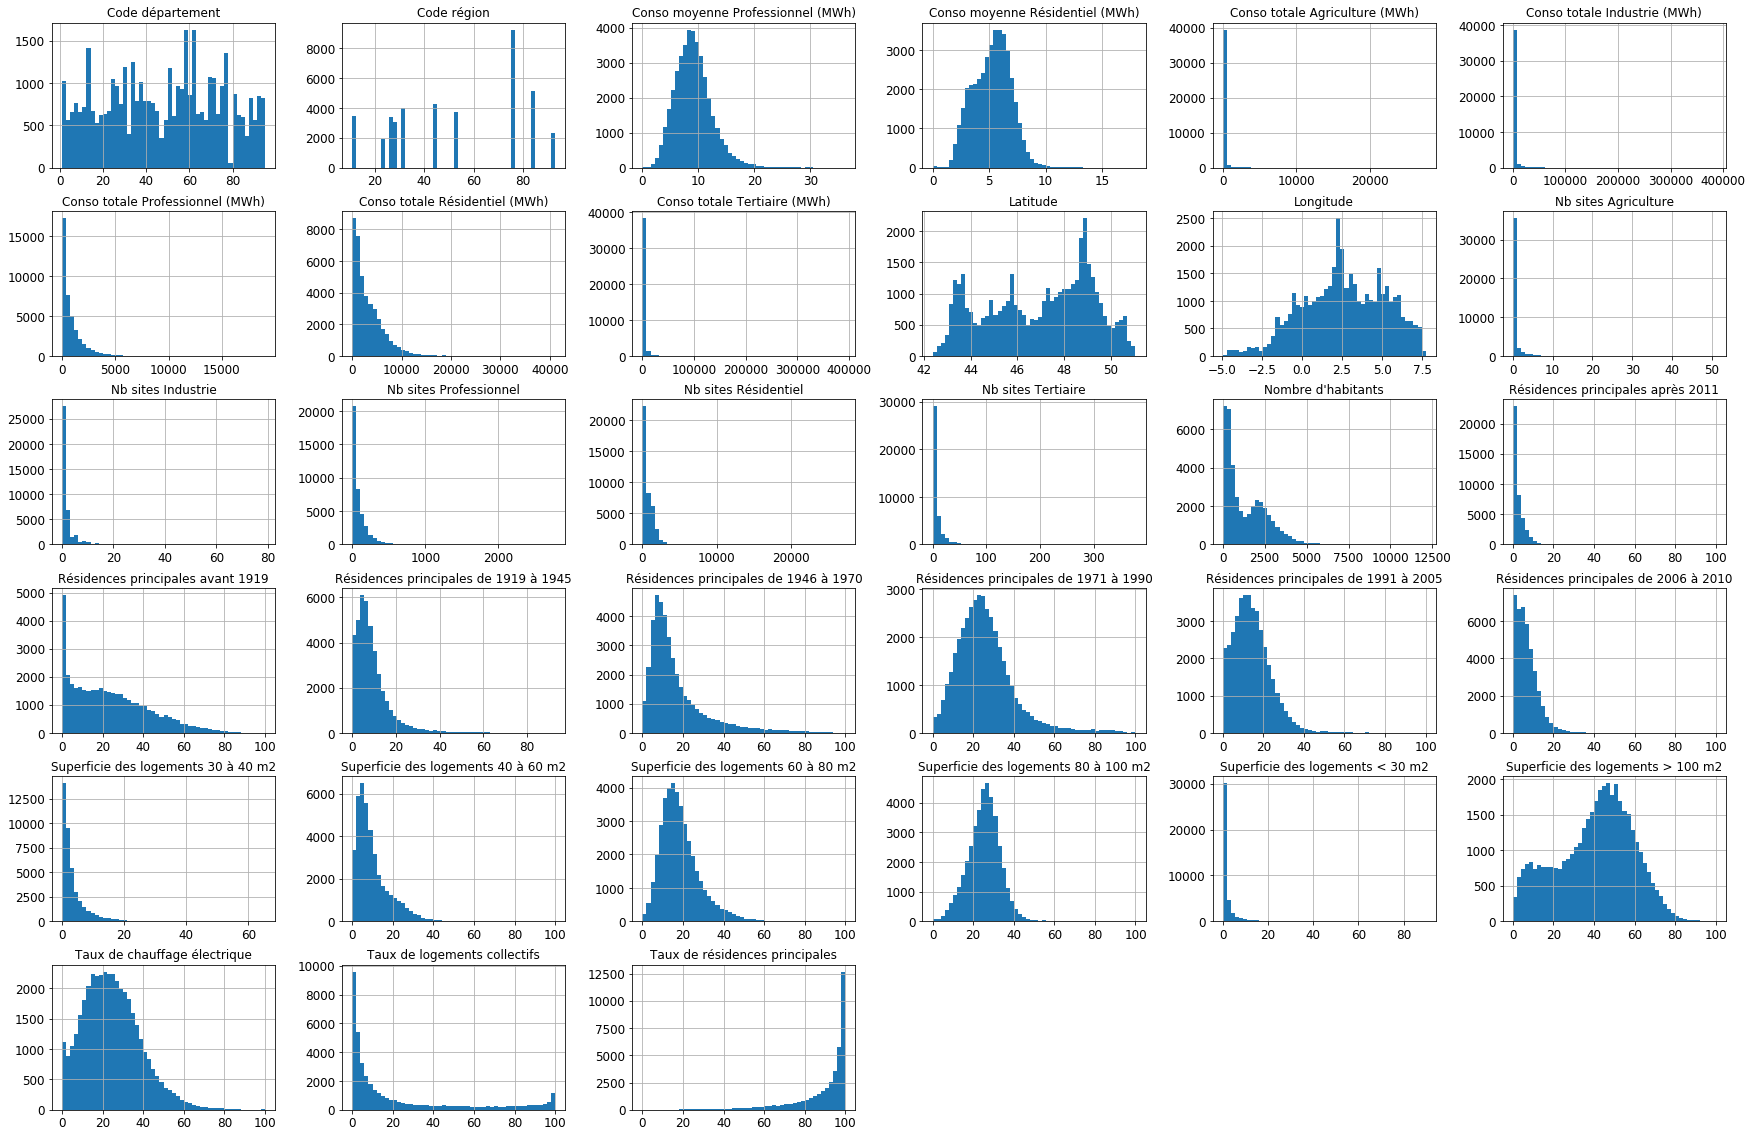

In [17]:
conso_per_iris_set.hist(bins=50, figsize=(30,20))
plt.show();

## Study of outliers

Looking at the histogram above allow us to see if there is any outliers. The most "promising" features where there may be some outliers are the consumption (total and average) and the number of sites.

So first we will study one by one the total consumption as a function of number of sites

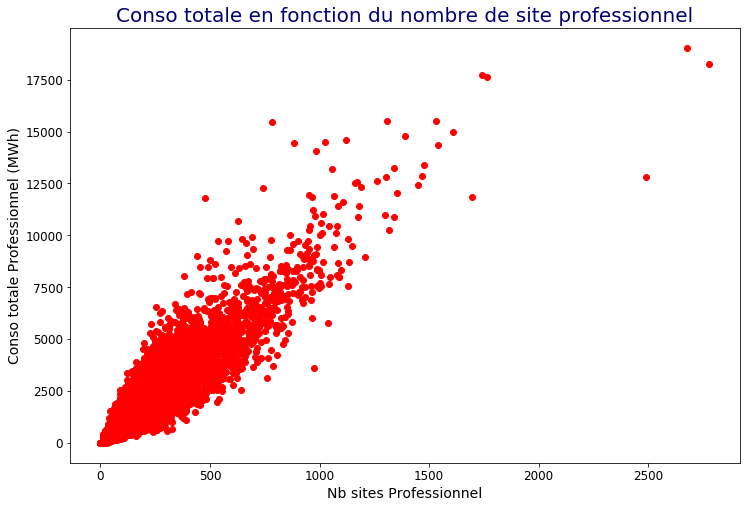

In [18]:
plt.close()
fig = plt.figure(figsize=(12,8))
ax = plt.axes()

plt.rcParams.update({'font.size': 15})

plt.scatter(conso_per_iris_set['Nb sites Professionnel'], conso_per_iris_set['Conso totale Professionnel (MWh)'],
         c='#FF0000')

plt.title("Conso totale en fonction du nombre de site professionnel", size=20, color="#000070")

# Titres des axes
ax = ax.set(xlabel='Nb sites Professionnel', ylabel='Conso totale Professionnel (MWh)')
plt.show()

Here, if we put aside the three dot on the top right corner, we don't see any outliers. Moreover we do not have a lot of value to train on when `Conso totale Professionnel` is greater than 12000 MWh or `Nb sites Professionnel` is greater than 1250

In [19]:
conso_per_iris_set = conso_per_iris_set[conso_per_iris_set['Nb sites Professionnel'] <= 1250]  
conso_per_iris_set = conso_per_iris_set[conso_per_iris_set['Conso totale Professionnel (MWh)'] <= 12000]  

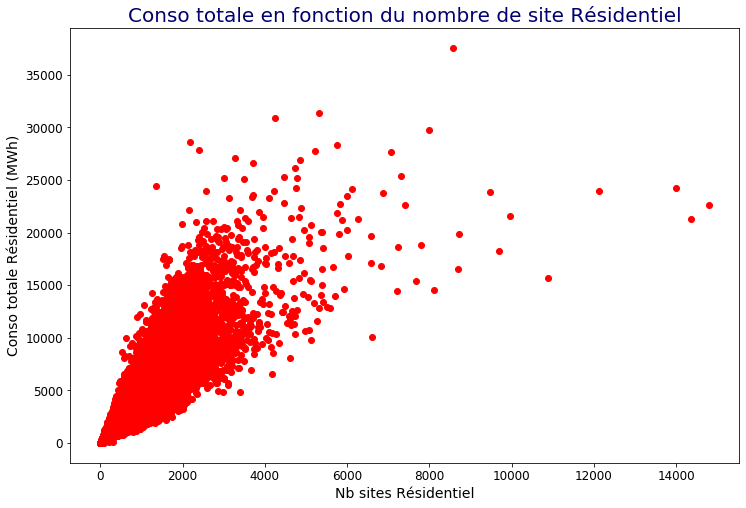

In [20]:
plt.close()
fig = plt.figure(figsize=(12,8))
ax = plt.axes()

plt.rcParams.update({'font.size': 15})

plt.scatter(conso_per_iris_set['Nb sites Résidentiel'], conso_per_iris_set['Conso totale Résidentiel (MWh)'],
         c='#FF0000')

plt.title("Conso totale en fonction du nombre de site Résidentiel", size=20, color="#000070")

# Titres des axes
ax = ax.set(xlabel='Nb sites Résidentiel', ylabel='Conso totale Résidentiel (MWh)')
plt.show()

Here again no dot seem to be an outlier which we absolutely need to get rid of. However when the number of sites is greater than 10000 or when the total consumption is greater than 30000 MWh, we clearly do not have enough data so we will drop this rows

In [21]:
conso_per_iris_set = conso_per_iris_set[conso_per_iris_set['Nb sites Résidentiel'] <= 6500]  
conso_per_iris_set = conso_per_iris_set[conso_per_iris_set['Conso totale Résidentiel (MWh)'] <= 25000]  

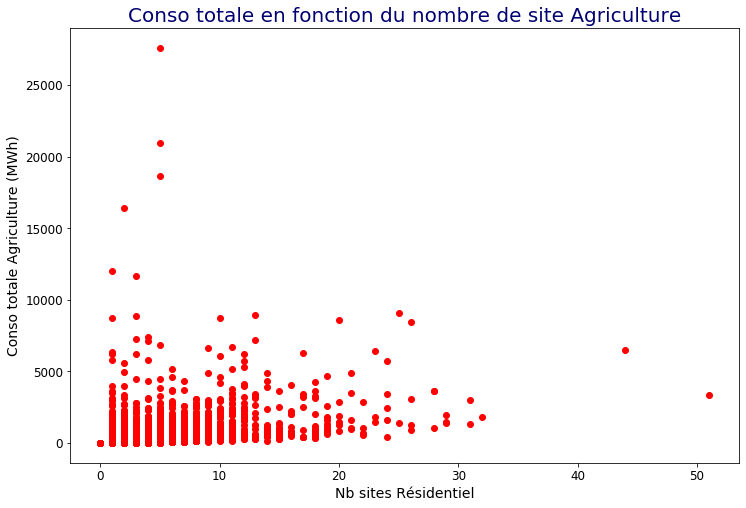

In [22]:
plt.close()
fig = plt.figure(figsize=(12,8))
ax = plt.axes()

plt.rcParams.update({'font.size': 15})

plt.scatter(conso_per_iris_set['Nb sites Agriculture'], conso_per_iris_set['Conso totale Agriculture (MWh)'],
         c='#FF0000')

plt.title("Conso totale en fonction du nombre de site Agriculture", size=20, color="#000070")

# Titres des axes
ax = ax.set(xlabel='Nb sites Résidentiel', ylabel='Conso totale Agriculture (MWh)')
plt.show()

I don't think we have enough data when the number os residential sites is greater than 20 or when the total consumption is greater than 6000

In [23]:
conso_per_iris_set = conso_per_iris_set[conso_per_iris_set['Nb sites Agriculture'] < 20]
conso_per_iris_set = conso_per_iris_set[conso_per_iris_set['Conso totale Agriculture (MWh)'] <= 6000]  

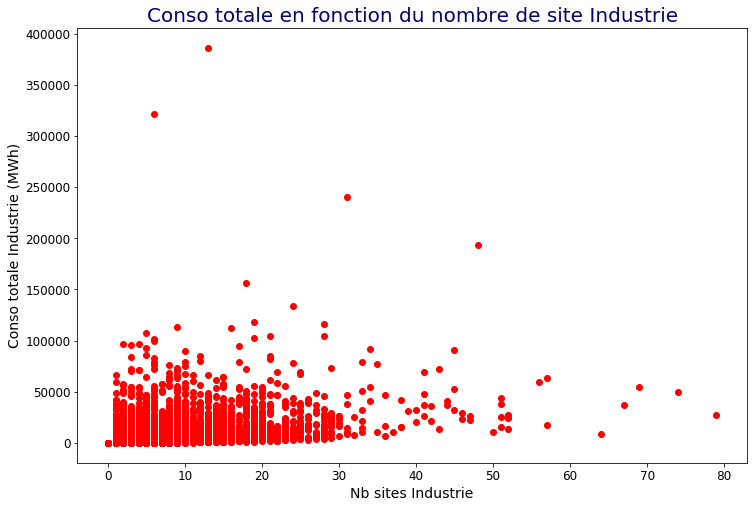

In [24]:
plt.close()
fig = plt.figure(figsize=(12,8))
ax = plt.axes()

plt.rcParams.update({'font.size': 15})

plt.scatter(conso_per_iris_set['Nb sites Industrie'], conso_per_iris_set['Conso totale Industrie (MWh)'],
         c='#FF0000')

plt.title("Conso totale en fonction du nombre de site Industrie", size=20, color="#000070")

# Titres des axes
ax = ax.set(xlabel='Nb sites Industrie', ylabel='Conso totale Industrie (MWh)')
plt.show()

With similar observation as above we will drop values where the number of sites is greater than 40 or where the total consumption is greater than 80000

In [25]:
conso_per_iris_set = conso_per_iris_set[conso_per_iris_set['Nb sites Industrie'] <= 40]
conso_per_iris_set = conso_per_iris_set[conso_per_iris_set['Conso totale Industrie (MWh)'] <= 80000]  

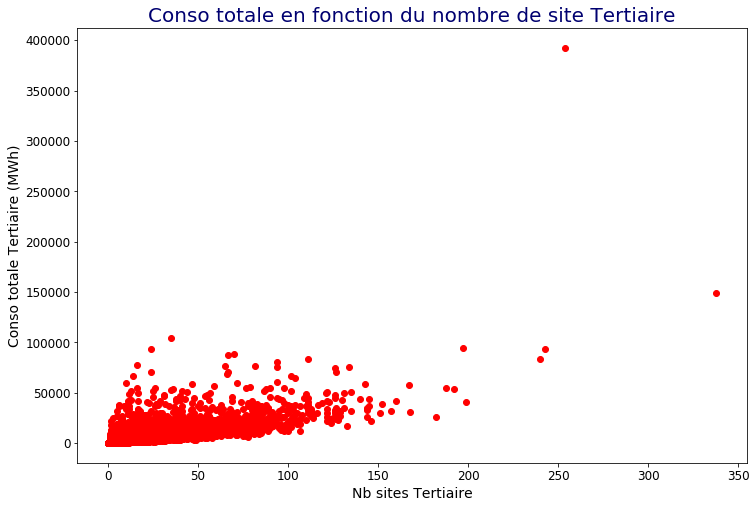

In [26]:
plt.close()
fig = plt.figure(figsize=(12,8))
ax = plt.axes()

plt.rcParams.update({'font.size': 15})

plt.scatter(conso_per_iris_set['Nb sites Tertiaire'], conso_per_iris_set['Conso totale Tertiaire (MWh)'],
         c='#FF0000')

plt.title("Conso totale en fonction du nombre de site Tertiaire", size=20, color="#000070")

# Titres des axes
ax = ax.set(xlabel='Nb sites Tertiaire', ylabel='Conso totale Tertiaire (MWh)')
plt.show()

Again we will drop values where the total consumption is greater than 50000 or the number os site is greater than 110

In [27]:
conso_per_iris_set = conso_per_iris_set[conso_per_iris_set['Conso totale Tertiaire (MWh)'] <= 50000]
conso_per_iris_set = conso_per_iris_set[conso_per_iris_set['Nb sites Tertiaire'] <= 110]  

## Scale Data
As we can see on the above graph, some features need to be scaled. But first we have to distinct the training set from the testing set. Indeed the testing set need to be scaled with mean and std of the training set

### Create a Test Set

In [28]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(conso_per_iris_set, test_size=0.2, random_state=42)
print(train_set.shape, test_set.shape)

(32212, 37) (8053, 37)


Now, scale data

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

def scaling(train, test, scaler, features_to_scale):
    scaled_train = train.copy()
    scaled_test = test.copy()
    features_train = scaled_train[features_to_scale]
    features_test = scaled_test[features_to_scale]
    
    scaler = scaler.fit(features_train.values)
    features_train = scaler.transform(features_train.values)
    features_test = scaler.transform(features_test.values)
    
    scaled_train[features_to_scale] = features_train
    scaled_test[features_to_scale] = features_test
    return scaled_train, scaled_test

In [30]:
scaled_train_set, scaled_test_set = scaling(train_set, test_set,scaler, 
                            ["Nombre d'habitants","Taux de résidences principales", "Nb sites Tertiaire",
                            "Nb sites Agriculture", "Nb sites Industrie", "Nb sites Résidentiel", "Nb sites Professionnel",
                            "Taux de logements collectifs", "Superficie des logements < 30 m2", "Superficie des logements 30 à 40 m2",
                             "Superficie des logements 40 à 60 m2","Superficie des logements 60 à 80 m2","Superficie des logements 80 à 100 m2",
                             "Superficie des logements > 100 m2","Résidences principales avant 1919", "Résidences principales de 1919 à 1945",
                             "Résidences principales de 1946 à 1970","Résidences principales de 1971 à 1990","Résidences principales de 1991 à 2005",
                             "Résidences principales de 2006 à 2010","Résidences principales après 2011","Taux de chauffage électrique",
                            "Latitude","Longitude"])

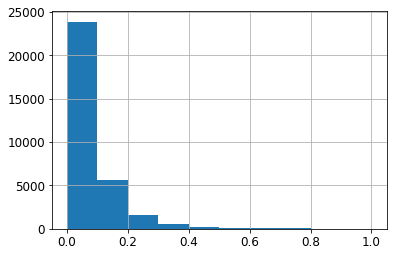

In [31]:
#conso_per_iris["Nombre d'habitants"].hist()
#conso_per_iris["Taux de résidences principales"].hist()
#conso_per_iris["Nb sites Tertiaire"].hist()
#conso_per_iris["Nb sites Agriculture"].hist()
#conso_per_iris["Nb sites Industrie"].hist()
#conso_per_iris["Nb sites Résidentiel"].hist()
scaled_train_set["Nb sites Professionnel"].hist()

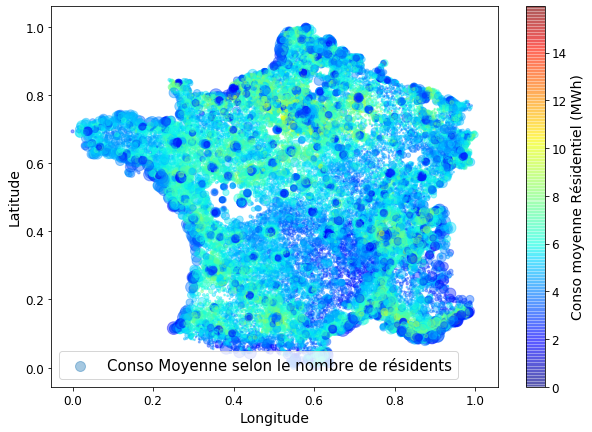

In [32]:
scaled_train_set.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.4,
             s=scaled_train_set["Nb sites Résidentiel"]*200, label="Conso Moyenne selon le nombre de résidents", figsize=(10,7),
             c="Conso moyenne Résidentiel (MWh)", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False) # last argument for a library bug
plt.legend();

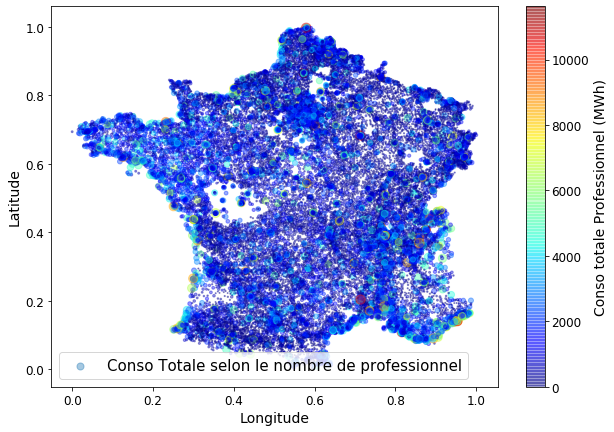

In [33]:
scaled_train_set.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.4,
             s=scaled_train_set["Nb sites Professionnel"]*100, label="Conso Totale selon le nombre de professionnel", figsize=(10,7),
             c="Conso totale Professionnel (MWh)", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False) 
plt.legend();

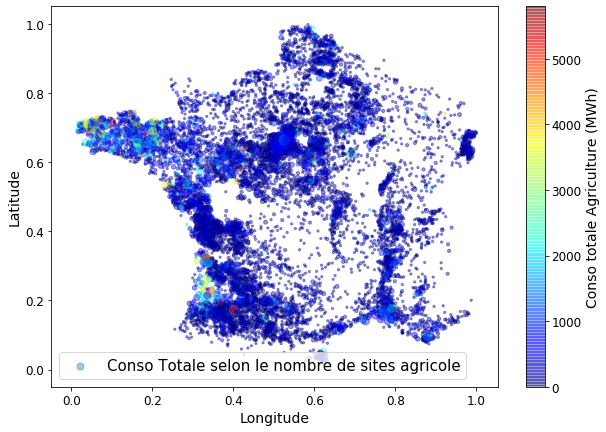

In [34]:
scaled_train_set.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.4,
             s=scaled_train_set["Nb sites Agriculture"]*100, label="Conso Totale selon le nombre de sites agricole", figsize=(10,7),
             c="Conso totale Agriculture (MWh)", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend();

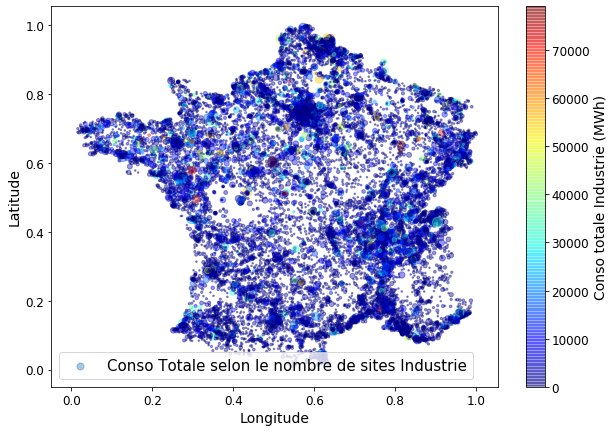

In [35]:
scaled_train_set.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.4,
             s=scaled_train_set["Nb sites Industrie"]*100, label="Conso Totale selon le nombre de sites Industrie", figsize=(10,7),
             c="Conso totale Industrie (MWh)", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False) 
plt.legend();

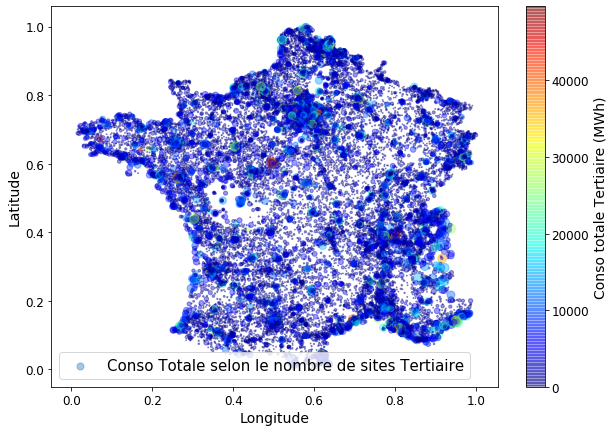

In [36]:
scaled_train_set.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.4,
             s=scaled_train_set["Nb sites Tertiaire"]*100, label="Conso Totale selon le nombre de sites Tertiaire", figsize=(10,7),
             c="Conso totale Tertiaire (MWh)", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False) 
plt.legend();

### 4. Are there major differences in consumption by department or region? If so, what are these differences? Propose some reason behind these differences
We will begin by question 4 because it we explain our approach later.

For this analyse we will use pivot table as it is a very easy and efficient way to respond to our question. As it it only to study and we won't change the data, we will use the full dataset

In [37]:
table = pd.pivot_table(conso_per_iris_set, values=['Conso totale Résidentiel (MWh)', 'Conso totale Professionnel (MWh)',
                                               'Conso totale Agriculture (MWh)', 'Conso totale Industrie (MWh)',
                                               'Conso totale Tertiaire (MWh)'], index=['Nom région'],aggfunc=np.mean)
table

Conso totale Agriculture (MWh)  Conso totale Industrie (MWh)  Conso totale Professionnel (MWh)  Conso totale Résidentiel (MWh)  Conso totale Tertiaire (MWh)
Nom région                                                                                                                                                                              
Auvergne-Rhône-Alpes                             30.560343                   1563.027984                       1005.296066                     3348.113631                   1784.519479
Bourgogne-Franche-Comté                          16.752006                   1026.805116                        547.882194                     1828.578684                    885.018275
Bretagne                                        330.783375                   2121.549318                       1370.509834                     4594.535602                   2241.872875
Centre-Val de Loire                             112.988842                   1329.092982                        781.978694                     3223.946956                   1532.691068
Grand-Est                                        29.748276                   1287.362128                        577.347769                     2025.164178                   1036.516291
Hauts-de-France                                  48.172719                   1447.994290                        771.956834                     2836.068826                   1569.092237
Normandie                                        30.597168                   1275.246623                        701.028405                     2520.483935                   1189.889575
Nouvelle Aquitaine                               83.143541                    929.612406                        796.786183                     3066.676903                   1419.920600
Occitanie                                        41.415543                    637.433088                        796.072585                     2973.288209                   1323.449922
Pays de la Loire                                143.590495                   2165.380955                       1187.299330                     4410.550028                   2143.072513
Provence-Alpes-Côte d'Azur                       46.411944                    686.727403                       1525.752875                     5724.644739                   2861.001375
Île-de-France                                    14.074457                    816.976888                       1158.520124                     4353.016713                   3154.455658

In [38]:
table = pd.pivot_table(conso_per_iris_set, values=['Conso totale Résidentiel (MWh)', 'Conso totale Professionnel (MWh)',
                                               'Conso totale Agriculture (MWh)', 'Conso totale Industrie (MWh)',
                                               'Conso totale Tertiaire (MWh)'], index=['Nom département'],aggfunc=np.mean)
table

Conso totale Agriculture (MWh)  Conso totale Industrie (MWh)  Conso totale Professionnel (MWh)  Conso totale Résidentiel (MWh)  Conso totale Tertiaire (MWh)
Nom département                                                                                                                                                                      
Ain                                           66.687958                   2338.325829                        921.483713                     3617.177242                   1661.652805
Aisne                                         36.325278                   1322.323375                        477.629404                     1852.876375                    828.307114
Allier                                        45.813045                    957.300324                        649.216729                     2340.032857                   1206.733983
Alpes-Maritimes                                5.934704                    660.360562                       1833.544006                     6166.110186                   3484.214179
Alpes-de-Haute-Provence                       38.189533                    562.862061                        754.379629                     2712.171796                   1302.614296
Ardennes                                      18.574633                   1138.227020                        423.366101                     1299.593496                    530.927313
Ardèche                                       14.759934                   1227.739901                        638.168415                     2499.854742                    846.410700
Ariège                                         9.269349                    377.248239                        378.054763                     1334.277840                    460.995031
Aube                                          84.780669                   1266.353417                        534.020203                     1860.721010                    959.718574
Aude                                          34.923941                    364.346265                        574.969282                     2457.738606                    796.354708
Aveyron                                       39.712662                    876.775576                        906.358184                     2078.527210                    888.892951
Bas-Rhin                                      41.268312                   1384.729465                        521.132428                     2055.275560                    706.497725
Bouches-du-Rhône                              49.519396                    758.225138                       1548.510747                     5727.902668                   2975.311160
Calvados                                      29.206612                   1047.108896                        734.496517                     2606.298334                   1301.655511
Cantal                                         6.752122                    484.080030                        608.074430                     1354.850997                    554.965930
Charente                                      78.579005                   1192.451677                        552.623638                     2211.190026                   1023.304995
Charente-Maritime                             94.280785                    528.585996                        856.973978                     3869.664111                   1478.086618
Cher                                          74.320302                    879.638044                        668.362710                     2592.882265                   1173.087032
Corrèze                                        6.443467                    707.311583                        560.297513                     2090.254245                    950.232477
Creuse                                         7.492947                    401.970020                        352.303146                     1234.373818                    374.421220
Côte-d'Or            

It is obvious that, from a region to another, from a departement to another, the total consumption is changing a lot. So we want to say that obviously the consumption is affected by the location. 

However, I want to draw you attention on the values we are showing. Indeed these values are the mean (of a region or departement) of the total value of consumption expressed in MWh. Therefore, if a region (or departement) has a bigger number of sites than another, then it may have also a bigger consumtpion. Therefore, I propose to see the mean of average consumption by region/departement and we'll try to see if the location is relevant.

In [39]:
conso_per_iris_set['Conso moyenne Agriculture (MWh)'] = conso_per_iris_set['Conso totale Agriculture (MWh)'] / conso_per_iris_set['Nb sites Agriculture'] 
conso_per_iris_set['Conso moyenne Industrie (MWh)'] = conso_per_iris_set['Conso totale Industrie (MWh)'] / conso_per_iris_set['Nb sites Industrie'] 
conso_per_iris_set['Conso moyenne Tertiaire (MWh)'] = conso_per_iris_set['Conso totale Tertiaire (MWh)'] / conso_per_iris_set['Nb sites Tertiaire'] 
conso_per_iris_set[["Conso moyenne Agriculture (MWh)", "Conso moyenne Industrie (MWh)", "Conso moyenne Tertiaire (MWh)"]
                  ] = conso_per_iris_set[["Conso moyenne Agriculture (MWh)", "Conso moyenne Industrie (MWh)","Conso moyenne Tertiaire (MWh)"]].fillna(0)

In [40]:
table = pd.pivot_table(conso_per_iris_set, values=['Conso moyenne Résidentiel (MWh)', 'Conso moyenne Professionnel (MWh)',
                                               'Conso moyenne Agriculture (MWh)', 'Conso moyenne Industrie (MWh)',
                                               'Conso moyenne Tertiaire (MWh)'], index=['Nom région'],aggfunc=np.mean)
table

Conso moyenne Agriculture (MWh)  Conso moyenne Industrie (MWh)  Conso moyenne Professionnel (MWh)  Conso moyenne Résidentiel (MWh)  Conso moyenne Tertiaire (MWh)
Nom région                                                                                                                                                                                   
Auvergne-Rhône-Alpes                              16.189866                     291.193944                           8.263001                         4.929041                     148.885639
Bourgogne-Franche-Comté                           11.124973                     294.905099                           8.058324                         5.056949                     108.470886
Bretagne                                          94.220360                     467.005690                          11.191981                         4.985377                     202.318007
Centre-Val de Loire                               34.246401                     288.594106                           8.556319                         5.823484                     142.148574
Grand-Est                                         17.319554                     358.592678                           8.515225                         5.505380                     121.088263
Hauts-de-France                                   27.816700                     423.150323                          10.099556                         5.377658                     159.070286
Normandie                                         22.546326                     327.686151                          10.079457                         5.994238                     132.813848
Nouvelle Aquitaine                                30.333580                     238.573132                           8.121441                         5.380879                     131.823911
Occitanie                                         19.630525                     159.417871                           8.062072                         5.104756                     121.456702
Pays de la Loire                                  51.233312                     413.955234                          10.835946                         5.524022                     168.050407
Provence-Alpes-Côte d'Azur                        16.116770                     163.434878                           8.758114                         4.805018                     196.922188
Île-de-France                                      8.174617                     213.386391                          10.700949                         4.836487                     230.207702

In [41]:
table = pd.pivot_table(conso_per_iris_set, values=['Conso moyenne Résidentiel (MWh)', 'Conso moyenne Professionnel (MWh)',
                                               'Conso moyenne Agriculture (MWh)', 'Conso moyenne Industrie (MWh)',
                                               'Conso moyenne Tertiaire (MWh)'], index=['Nom département'],aggfunc=np.mean)
table

Conso moyenne Agriculture (MWh)  Conso moyenne Industrie (MWh)  Conso moyenne Professionnel (MWh)  Conso moyenne Résidentiel (MWh)  Conso moyenne Tertiaire (MWh)
Nom département                                                                                                                                                                           
Ain                                            30.572139                     372.036971                           8.898066                         5.940010                     162.751578
Aisne                                          22.143850                     463.638433                           8.188315                         5.858280                     131.415978
Allier                                         18.732371                     195.700634                           7.116949                         5.207460                     128.043366
Alpes-Maritimes                                 4.917814                     139.040374                           9.265390                         4.383229                     188.940732
Alpes-de-Haute-Provence                        15.504610                      77.271020                           7.654715                         4.574364                     107.292422
Ardennes                                       11.118635                     281.215333                           7.617447                         4.992035                      80.526089
Ardèche                                        12.588461                     337.820208                           7.330632                         4.493293                     104.434974
Ariège                                          5.235404                     145.355644                           5.852767                         4.394941                      68.873127
Aube                                           37.569173                     394.526328                           7.793460                         6.007099                     123.546178
Aude                                           25.268481                     143.836256                           8.568223                         5.106721                     103.843677
Aveyron                                        26.291644                     176.015856                           8.213114                         4.370832                     102.898619
Bas-Rhin                                       19.386503                     327.480240                           8.763200                         5.531782                     132.279173
Bouches-du-Rhône                               12.637617                     184.217116                           8.705546                         4.768764                     235.206167
Calvados                                       18.709654                     256.866529                          10.022415                         6.074276                     127.188116
Cantal                                          6.691691                     124.454276                           7.147932                         4.004956                      55.106860
Charente                                       29.245062                     309.372407                           7.178228                         5.487043                     114.641053
Charente-Maritime                              29.522137                     142.337355                           7.330546                         5.927368                     135.017592
Cher                                           25.124103                     177.959797                           8.261784                         5.554568                     145.595122
Corrèze                                         6.011228                     153.872992                           6.435981                         4.690069                     110.678565
Creuse                                          6.563438                     176.963938           

Whereas consumption do not vary fluctuate for region, espcially for `Professionnel` `Résidentiel`, it fluctuates more between departements. It could be explained as the change in temperature or for the agriculture the need to heat barns for animals for example or the ratio of appartement and house for residential zone.

As it seems relevant to conside these values, it could be enteresting to use OneHotEncoder on the departement (doing this on region and departement would be redundant as departement is a sub-region). However as we have about 95 departement, it will add about 95 features to our dataframe and even if we use a PCA to reduce dimension, we could keep maybe 25% of this features which is already to much.

Therefore, we gonna use the coefficient determined here and associate each one of them to the department it describes. Therefore we will add five column to our dataframe we could still use a PCA do decrease dimension.

In [42]:
table = table.rename(columns={'Conso moyenne Résidentiel (MWh)' : 'Conso moyenne Résidentiel (MWh)_depart', 
                              'Conso moyenne Professionnel (MWh)':'Conso moyenne Professionnel (MWh)_depart',
                              'Conso moyenne Agriculture (MWh)':'Conso moyenne Agriculture (MWh)_depart', 
                              'Conso moyenne Industrie (MWh)':'Conso moyenne Industrie (MWh)_depart',
                              'Conso moyenne Tertiaire (MWh)':'Conso moyenne Tertiaire (MWh)_depart'})
conso_per_iris_set = pd.merge(conso_per_iris_set, table, on='Nom département').drop(["Code département", "Nom région","Code région"], axis=1) 
conso_per_iris_set.head(100)

Type IRIS Type EPCI Nom département  Nb sites Résidentiel  Conso totale Résidentiel (MWh)  Conso moyenne Résidentiel (MWh)  Nb sites Professionnel  Conso totale Professionnel (MWh)  Conso moyenne Professionnel (MWh)  Nb sites Agriculture  Conso totale Agriculture (MWh)  Nb sites Industrie  Conso totale Industrie (MWh)  Nb sites Tertiaire  Conso totale Tertiaire (MWh)  Nombre d'habitants  Taux de logements collectifs  Taux de résidences principales  Superficie des logements < 30 m2  Superficie des logements 30 à 40 m2  Superficie des logements 40 à 60 m2  Superficie des logements 60 à 80 m2  Superficie des logements 80 à 100 m2  Superficie des logements > 100 m2  Résidences principales avant 1919  Résidences principales de 1919 à 1945  Résidences principales de 1946 à 1970  Résidences principales de 1971 à 1990  Résidences principales de 1991 à 2005  Résidences principales de 2006 à 2010  Résidences principales après 2011  Taux de chauffage électrique   Latitude  Longitude  \
0          H        CU       Finistère                1131.0                     4215.912353                         3.727597                    87.0                        706.146914                           8.116631                     0                        0.000000                   0                      0.000000                  11                   3318.677905                2370                     34.172348                       98.648300                          0.376911                             6.802959                             7.680954                            16.960795                             31.727496                          36.450883                           1.102964                               0.644358                              42.114763                              43.444992                               6.253519                               5.315456                       1.123948e+00                     25.432237  48.419883  -4.482023   
1          Z        CA       Finistère                1428.0                     7302.455645                         5.113764                   180.0                       2286.541280                          12.703007                     7                     2580.485926                   4                    828.322584                  14                   2697.849438                3083                      2.860039                       93.795585                          0.530306                             2.803033                             7.954548                            18.863633                             28.712121                          41.136360                          16.742425                               5.757577                              20.909092                              33.484850                              14.469698                               5.757577                       2.878781e+00                     24.696965  48.510737  -3.871679   
2          H        CC       Finistère                1699.0                     6776.163701                         3.988325                   295.0                       3135.881966                          10.630108                     1                       10.676032                  10                  13850.369070                  27                  11862.375593                2700                     28.894371                       93.671847                          4.932607                             6.159633                            16.060316                            24.786218                             23.545368                          24.515872                           7.206133                              10.125202                              39.663644                              28.587355                               8.230242                               5.757639                       4.297850e-01                     26.165571  48.283391  -3.572297   
3          Z        CA       Fi

### 1. Is electricity consumption explainable from external data?

In [43]:
conso_per_iris_set.head(700)

Type IRIS Type EPCI Nom département  Nb sites Résidentiel  Conso totale Résidentiel (MWh)  Conso moyenne Résidentiel (MWh)  Nb sites Professionnel  Conso totale Professionnel (MWh)  Conso moyenne Professionnel (MWh)  Nb sites Agriculture  Conso totale Agriculture (MWh)  Nb sites Industrie  Conso totale Industrie (MWh)  Nb sites Tertiaire  Conso totale Tertiaire (MWh)  Nombre d'habitants  Taux de logements collectifs  Taux de résidences principales  Superficie des logements < 30 m2  Superficie des logements 30 à 40 m2  Superficie des logements 40 à 60 m2  Superficie des logements 60 à 80 m2  Superficie des logements 80 à 100 m2  Superficie des logements > 100 m2  Résidences principales avant 1919  Résidences principales de 1919 à 1945  Résidences principales de 1946 à 1970  Résidences principales de 1971 à 1990  Résidences principales de 1991 à 2005  Résidences principales de 2006 à 2010  Résidences principales après 2011  Taux de chauffage électrique   Latitude  Longitude  \
0           H        CU       Finistère                1131.0                     4215.912353                         3.727597                    87.0                        706.146914                           8.116631                     0                        0.000000                   0                      0.000000                  11                   3318.677905                2370                     34.172348                       98.648300                          0.376911                             6.802959                             7.680954                            16.960795                             31.727496                          36.450883                           1.102964                               0.644358                              42.114763                              43.444992                               6.253519                               5.315456                       1.123948e+00                     25.432237  48.419883  -4.482023   
1           Z        CA       Finistère                1428.0                     7302.455645                         5.113764                   180.0                       2286.541280                          12.703007                     7                     2580.485926                   4                    828.322584                  14                   2697.849438                3083                      2.860039                       93.795585                          0.530306                             2.803033                             7.954548                            18.863633                             28.712121                          41.136360                          16.742425                               5.757577                              20.909092                              33.484850                              14.469698                               5.757577                       2.878781e+00                     24.696965  48.510737  -3.871679   
2           H        CC       Finistère                1699.0                     6776.163701                         3.988325                   295.0                       3135.881966                          10.630108                     1                       10.676032                  10                  13850.369070                  27                  11862.375593                2700                     28.894371                       93.671847                          4.932607                             6.159633                            16.060316                            24.786218                             23.545368                          24.515872                           7.206133                              10.125202                              39.663644                              28.587355                               8.230242                               5.757639                       4.297850e-01                     26.165571  48.283391  -3.572297   
3           Z        CA     

## Looking for correlations
### 2. What are the features, or group of features correlated with electricity consumption?
Since the dataset is not too large, we can easily compute the standard correlation coefficient between every pair of attributes using the `corr()` method:

In [45]:
corr_matrix = scaled_train_set.corr()
corr_matrix

Code département  Code région  Nb sites Résidentiel  Conso totale Résidentiel (MWh)  Conso moyenne Résidentiel (MWh)  Nb sites Professionnel  Conso totale Professionnel (MWh)  Conso moyenne Professionnel (MWh)  Nb sites Agriculture  Conso totale Agriculture (MWh)  Nb sites Industrie  Conso totale Industrie (MWh)  Nb sites Tertiaire  Conso totale Tertiaire (MWh)  Nombre d'habitants  Taux de logements collectifs  Taux de résidences principales  Superficie des logements < 30 m2  Superficie des logements 30 à 40 m2  Superficie des logements 40 à 60 m2  Superficie des logements 60 à 80 m2  Superficie des logements 80 à 100 m2  Superficie des logements > 100 m2  Résidences principales avant 1919  Résidences principales de 1919 à 1945  Résidences principales de 1946 à 1970  Résidences principales de 1971 à 1990  Résidences principales de 1991 à 2005  Résidences principales de 2006 à 2010  Résidences principales après 2011  Taux de chauffage électrique  \
Code département                               1.000000    -0.387774              0.093374                        0.073164                        -0.040442                0.030144                          0.056979                           0.157243             -0.079773                       -0.049203            0.023649                      0.010369            0.074610                      0.076537            0.159130                      0.162834                        0.182905                          0.076282                             0.096643                             0.122308                             0.084869                             -0.084430                          -0.103972                          -0.163911                               0.017904                               0.138545                               0.094390                              -0.004929                              -0.055736                          -0.042615                     -0.046672   
Code région                                   -0.387774     1.000000              0.081299                        0.096294                        -0.069716                0.132851                          0.082161                          -0.183106              0.041543                        0.025992            0.059758                     -0.011263            0.035507                      0.002205           -0.005001                     -0.006343                       -0.267763                         -0.015971                            -0.007794                            -0.033897                            -0.054021                             -0.021717                           0.057275                           0.051677                              -0.130281                              -0.093501                              -0.050318                               0.138304                               0.118748                           0.093921                      0.152562   
Nb sites Résidentiel                           0.093374     0.081299              1.000000                        0.882478                        -0.375492                0.810396                          0.775710                           0.127550              0.002140                        0.047192            0.367893                      0.146666            0.604148                      0.429028            0.906366                      0.592726                        0.163402                          0.357259                             0.486280                             0.505829                             0.369178                             -0.199436                          -0.531352                          -0.476407                              -0.007492                               0.351689                               0.216996                               0.106117                              -0.039554                          -0.028471                      0.321609   
Conso totale Résidentiel (MWh)     

As we want to see the correlation between features we will, for each consumption sector, the correlation Matrix 

### Résidentiel

In [46]:
corr_matrix["Conso moyenne Résidentiel (MWh)"].sort_values(ascending=False)

Conso moyenne Résidentiel (MWh)          1.000000
Superficie des logements > 100 m2        0.720537
Taux de chauffage électrique             0.380368
Résidences principales de 1991 à 2005    0.330107
Résidences principales de 2006 à 2010    0.309253
Superficie des logements 80 à 100 m2     0.241032
Nb sites Agriculture                     0.218957
Résidences principales après 2011        0.172523
Résidences principales avant 1919        0.167968
Taux de résidences principales           0.163581
Conso moyenne Professionnel (MWh)        0.121681
Conso totale Agriculture (MWh)           0.114325
Latitude                                 0.079076
Résidences principales de 1971 à 1990    0.025865
Conso totale Industrie (MWh)            -0.016774
Conso totale Résidentiel (MWh)          -0.021664
Nb sites Industrie                      -0.037325
Code département                        -0.040442
Code région                             -0.069716
Longitude                               -0.077581


In [47]:
corr_matrix["Conso totale Résidentiel (MWh)"].sort_values(ascending=False)

Conso totale Résidentiel (MWh)           1.000000
Nb sites Résidentiel                     0.882478
Nombre d'habitants                       0.877340
Conso totale Professionnel (MWh)         0.674545
Nb sites Professionnel                   0.651837
Nb sites Tertiaire                       0.536511
Taux de chauffage électrique             0.470256
Nb sites Industrie                       0.425085
Conso totale Tertiaire (MWh)             0.382533
Taux de logements collectifs             0.296508
Résidences principales de 1971 à 1990    0.262275
Superficie des logements 30 à 40 m2      0.260960
Résidences principales de 1991 à 2005    0.253967
Superficie des logements 40 à 60 m2      0.245423
Conso moyenne Professionnel (MWh)        0.206485
Taux de résidences principales           0.199024
Conso totale Industrie (MWh)             0.178180
Superficie des logements < 30 m2         0.175556
Superficie des logements 60 à 80 m2      0.150743
Résidences principales de 1946 à 1970    0.147024


As we can see, for the `Conso totale Résidentiel (MWh)` the features the best correlated are :
* `Nb sites Résidentiel`
* `Nombre d'habitants`
* `Conso totale Professionnel (MWh)`(which won't be used to predict because we will predict it)
* `Nb sites Professionnel`
* `Nb sites Tertiaire`
* `Taux de chauffage électrique`

However the `Conso moyenne Résidentiel (MWh)` seems to have less correlated features with a great correlated coefficient. Here are some features correlated :
* `Superficie des logements > 100 m2`
* `Taux de chauffage électrique`
* `Taux de logements collectifs `
* `Superficie des logements 40 à 60 m2`
* `Superficie des logements 60 à 80 m2`

### Professionnel 

In [48]:
corr_matrix["Conso totale Professionnel (MWh)"].sort_values(ascending=False)

Conso totale Professionnel (MWh)         1.000000
Nb sites Professionnel                   0.942166
Nb sites Tertiaire                       0.812402
Nb sites Résidentiel                     0.775710
Nombre d'habitants                       0.687169
Conso totale Résidentiel (MWh)           0.674545
Conso totale Tertiaire (MWh)             0.581900
Nb sites Industrie                       0.520042
Taux de logements collectifs             0.518409
Superficie des logements 30 à 40 m2      0.471914
Superficie des logements 40 à 60 m2      0.434208
Superficie des logements < 30 m2         0.370877
Taux de chauffage électrique             0.318166
Conso moyenne Professionnel (MWh)        0.280745
Superficie des logements 60 à 80 m2      0.270056
Résidences principales de 1946 à 1970    0.232688
Conso totale Industrie (MWh)             0.223981
Taux de résidences principales           0.137179
Résidences principales de 1971 à 1990    0.107079
Conso totale Agriculture (MWh)           0.084681


As we can see, for the `Conso totale Professionnel (MWh)` the features the best correlated are :
* `Nb sites Professionnel`
* `Nb sites Tertiaire`
* `Nb sites Résidentiel`
* `Conso totale Résidentiel (MWh)`(which won't be used to predict because we will predict it)
* `Nombre d'habitants`
* `Nb sites Industrie `

### Agriculture

In [49]:
corr_matrix["Conso totale Agriculture (MWh)"].sort_values(ascending=False)

Conso totale Agriculture (MWh)           1.000000
Nb sites Agriculture                     0.620316
Conso totale Résidentiel (MWh)           0.121748
Conso moyenne Professionnel (MWh)        0.118032
Conso moyenne Résidentiel (MWh)          0.114325
Taux de chauffage électrique             0.109589
Nb sites Industrie                       0.106512
Conso totale Professionnel (MWh)         0.084681
Superficie des logements > 100 m2        0.080623
Conso totale Industrie (MWh)             0.069616
Nombre d'habitants                       0.062440
Résidences principales de 2006 à 2010    0.061024
Superficie des logements 80 à 100 m2     0.060945
Résidences principales de 1991 à 2005    0.056985
Nb sites Résidentiel                     0.047192
Nb sites Tertiaire                       0.044842
Nb sites Professionnel                   0.040907
Résidences principales après 2011        0.037032
Conso totale Tertiaire (MWh)             0.031320
Code région                              0.025992


As we can see, for the `Conso totale Agriculture (MWh)` the features the best correlated is only :
* `Nb sites Agriculture`

### Industrie 

In [50]:
corr_matrix["Conso totale Industrie (MWh)"].sort_values(ascending=False)

Conso totale Industrie (MWh)             1.000000
Nb sites Industrie                       0.541859
Nb sites Tertiaire                       0.284264
Conso totale Tertiaire (MWh)             0.261183
Conso totale Professionnel (MWh)         0.223981
Nombre d'habitants                       0.182884
Conso totale Résidentiel (MWh)           0.178180
Nb sites Professionnel                   0.160614
Conso moyenne Professionnel (MWh)        0.153689
Nb sites Résidentiel                     0.146666
Taux de résidences principales           0.101127
Superficie des logements 80 à 100 m2     0.073029
Conso totale Agriculture (MWh)           0.069616
Résidences principales de 1971 à 1990    0.063515
Nb sites Agriculture                     0.056021
Résidences principales de 1946 à 1970    0.048096
Superficie des logements 60 à 80 m2      0.047993
Latitude                                 0.042440
Taux de chauffage électrique             0.040854
Résidences principales de 1991 à 2005    0.037158


As we can see, for the `Conso totale Industrie (MWh)` the features the best correlated are :
* `Nb sites Industrie`
* `Nb sites Tertiaire`
* `Conso totale Tertiaire (MWh)`(which won't be used to predict because we will predict it)
* `Conso totale Professionnel (MWh)`(which won't be used to predict because we will predict it)
* `Nombre d'habitants`

### Tertiaire 

In [51]:
corr_matrix["Conso totale Tertiaire (MWh)"].sort_values(ascending=False)

Conso totale Tertiaire (MWh)             1.000000
Nb sites Tertiaire                       0.800310
Conso totale Professionnel (MWh)         0.581900
Nb sites Professionnel                   0.484741
Nb sites Industrie                       0.476904
Nb sites Résidentiel                     0.429028
Nombre d'habitants                       0.428197
Conso totale Résidentiel (MWh)           0.382533
Taux de logements collectifs             0.334837
Superficie des logements < 30 m2         0.305493
Conso moyenne Professionnel (MWh)        0.265158
Superficie des logements 30 à 40 m2      0.265073
Conso totale Industrie (MWh)             0.261183
Superficie des logements 40 à 60 m2      0.247174
Taux de chauffage électrique             0.174215
Superficie des logements 60 à 80 m2      0.167754
Résidences principales de 1946 à 1970    0.154622
Résidences principales de 1971 à 1990    0.136338
Taux de résidences principales           0.123002
Résidences principales de 1991 à 2005    0.114776


As we can see, for the `Conso totale Tertiaire (MWh)` the features the best correlated are :
* `Nb sites Tertiaire`
* `Conso totale Professionnel (MWh)`(which won't be used to predict because we will predict it)
* `Nb sites Industrie`
* `Nb sites Professionnel`
* `Nombre d'habitants`
* `Nb sites Résidentiel`

The most promising attribute to predict the `Conso moyenne Résidentiel (MWh)` value is the `Superficie des logements > 100 m2`, so let's zoom in on their correlation scatterplot:

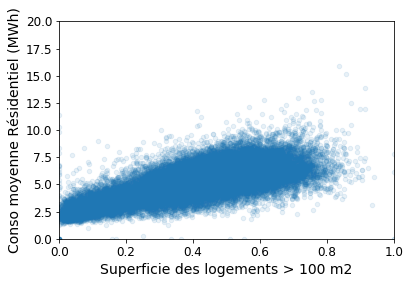

In [52]:
scaled_train_set.plot(kind="scatter", x="Superficie des logements > 100 m2", y="Conso moyenne Résidentiel (MWh)",
             alpha=0.1)
plt.axis([0, 1, 0, 20]);

## Decrease dimensions
### 3. There might be a lot of dimensions in your data, how can you reduce dimensionality while keeping a maximum of information?
This is not a secret, the best ways is to realize a dimensionality reduction is to use a PCA or a LDA algorithm. Indeed an algorithm like PCA will take all the features and create new ones but in smaller number.


In [53]:
def removeLabels(t_set, labels):
    X = t_set.drop(labels, axis=1) 
    y = t_set[labels].copy()
    return X, y

In [54]:
X_train, y_train = removeLabels(scaled_train_set.copy(), ["Conso moyenne Résidentiel (MWh)", "Conso moyenne Professionnel (MWh)",
                                 "Conso totale Résidentiel (MWh)", "Conso totale Professionnel (MWh)", 
                                 "Conso totale Agriculture (MWh)", "Conso totale Industrie (MWh)", "Conso totale Tertiaire (MWh)"])
X_test, y_test = removeLabels(scaled_test_set.copy(), ["Conso moyenne Résidentiel (MWh)", "Conso moyenne Professionnel (MWh)",
                                 "Conso totale Résidentiel (MWh)", "Conso totale Professionnel (MWh)", 
                                 "Conso totale Agriculture (MWh)", "Conso totale Industrie (MWh)", "Conso totale Tertiaire (MWh)"])


Performing PCA using Scikit-Learn is a two-step process:

1. Initialize the PCA class by passing the number of components to the constructor.
2. Call the fit and then transform methods by passing the feature set to these methods. The transform method returns the specified number of principal components.

We first prepare ou custom PCA in order to return 2 numpy array with a smaller number of dimension.

In [55]:
X_train.shape

(32212, 30)

In [56]:
from sklearn.decomposition import PCA

pca = PCA(n_components=18)

def customPCA(pca, X_train, X_test, features):
    X_train_pac = X_train[features]
    X_test_pac = X_test[features]
    
    X_train_pac = pca.fit_transform(X_train_pac)
    X_test_pac = pca.transform(X_test_pac)
    
    explained_variance = pca.explained_variance_ratio_
    print("Ratio of variance kept",pca.explained_variance_ratio_.sum()*100, "%")
    return np.hstack((X_train_pac, X_train.drop(features, axis=1))), np.hstack((X_test_pac, X_test.drop(features, axis=1)))

In [57]:
X_train_pca, X_test_pca = customPCA(pca, X_train, X_test, 
                              features = [ 'Nb sites Résidentiel', 'Nb sites Professionnel', 'Nb sites Agriculture', 
                                          'Nb sites Industrie', 'Nb sites Tertiaire', "Nombre d'habitants", 
                                          'Taux de logements collectifs', 'Taux de résidences principales', 
                                          'Superficie des logements < 30 m2', 'Superficie des logements 30 à 40 m2', 
                                          'Superficie des logements 40 à 60 m2', 'Superficie des logements 60 à 80 m2', 
                                          'Superficie des logements 80 à 100 m2', 'Superficie des logements > 100 m2', 
                                          'Résidences principales avant 1919', 'Résidences principales de 1919 à 1945', 
                                          'Résidences principales de 1946 à 1970', 'Résidences principales de 1971 à 1990', 
                                          'Résidences principales de 1991 à 2005', 'Résidences principales de 2006 à 2010', 
                                          'Résidences principales après 2011', 'Taux de chauffage électrique', 'Latitude', 
                                          'Longitude'])

Ratio of variance kept 99.00895558248396 %


In [58]:
X_train_pca.shape

(32212, 24)

### 5. Which departments have a large variation in electricity consumption? A small variation?

In [59]:
table = pd.pivot_table(conso_per_iris_set, values=['Conso totale Résidentiel (MWh)', 'Conso totale Professionnel (MWh)',
                                               'Conso totale Agriculture (MWh)', 'Conso totale Industrie (MWh)',
                                               'Conso totale Tertiaire (MWh)'], index=['Nom département'],aggfunc=np.std)
table

Conso totale Agriculture (MWh)  Conso totale Industrie (MWh)  Conso totale Professionnel (MWh)  Conso totale Résidentiel (MWh)  Conso totale Tertiaire (MWh)
Nom département                                                                                                                                                                      
Ain                                          203.313523                   6106.180044                       1049.664447                     3069.041181                   3837.358673
Aisne                                        108.821659                   5607.937467                        737.806858                     1772.945786                   1995.016138
Allier                                       130.822320                   4188.091278                        921.391517                     2076.205363                   3089.839045
Alpes-Maritimes                               29.866627                   3210.285652                       1575.017912                     4174.799404                   5306.027205
Alpes-de-Haute-Provence                      109.795083                   4233.224766                       1075.092084                     3242.578744                   2859.875359
Ardennes                                      95.913440                   4902.276199                        691.150899                     1420.062615                   1479.463594
Ardèche                                       82.457193                   4009.046644                        911.570604                     2296.258719                   1927.287725
Ariège                                        36.960500                   1713.458140                        687.233382                     1609.934349                   1406.668191
Aube                                         242.657351                   6016.664644                        908.689955                     1929.697069                   2391.165986
Aude                                         175.194006                   1647.038529                        727.140871                     2435.991761                   2509.238591
Aveyron                                       98.344773                   3796.305686                        917.472785                     2165.155386                   1975.314034
Bas-Rhin                                     132.148338                   5861.466639                        728.993987                     1771.834408                   1576.405791
Bouches-du-Rhône                             225.969837                   2964.636593                       1197.207353                     3620.125825                   4803.669700
Calvados                                     120.068660                   4542.118709                       1023.826233                     2309.989295                   3187.930361
Cantal                                        45.415903                   2051.754437                        857.670958                     1727.192439                   1692.356877
Charente                                     144.758052                   4191.578068                        811.938237                     2218.164521                   2918.822365
Charente-Maritime                            173.180120                   2251.024631                       1216.709018                     3973.052749                   3290.270545
Cher                                         181.116478                   3812.157071                        898.745738                     2521.206074                   2829.534320
Corrèze                                       27.212099                   2653.031515                        801.064346                     2192.939689                   2125.278257
Creuse                                        30.772145                   1955.610908                        554.622220                     1244.928537                   1190.499919
Côte-d'Or            

## Predict

After understanding all data, train a model on 2014 data to predict next year trends.

* Propose at least two different predictive methods, justify the choice motivation and explain the choice of your models’ parameters.

Optional but appreciable:
* Map visualization (on restricted areas or all territory)
* Dynamic application restitution


XGBoost
RandomForest